# GTFS Schedule
- Data: https://data.bus-data.dft.gov.uk/timetable/download/
- gtfs-kit: https://gitlab.com/mrcagney/gtfs_kit
- examples: https://gitlab.com/mrcagney/gtfs_kit/-/blob/master/notebooks/examples.ipynb
- docs:https://mrcagney.gitlab.io/gtfs_kit_docs/

## Imports

In [1]:
import warnings

import gtfs_kit as gk
import pandas as pd

In [2]:
warnings.filterwarnings("ignore")

## Load data and filter

Download one of the files from the bottom of the page here:

https://data.bus-data.dft.gov.uk/timetable/download/

In [3]:
path = "../data/itm_south_east_gtfs.zip"
feed = gk.read_feed(path, dist_units="mi")
# feed.validate()

In [4]:
agencies = {
    "OP376": "oxbc",
    "OP83": "stgc",  # stagecoach oxfordshire
    # "OP377": "thames travel",
    # "OP71": "redline bus",
    # "OP362": "red rose travel",
    # "OP50": "arriva",
}

In [5]:
routes = feed.routes.loc[feed.routes.agency_id.isin(agencies.keys())]
routes = routes.assign(route_name=routes.apply(lambda row: f"{agencies[row.agency_id]}-{row.route_short_name}", axis=1))
rids = routes.route_id.unique().tolist()
print(len(routes))
routes.head(3)

73


,route_id,agency_id,route_short_name,route_long_name,route_type,route_name
518,62678,OP376,100,NaN,3,oxbc-100
520,19092,OP376,11,NaN,3,oxbc-11
521,5907,OP376,11X,NaN,3,oxbc-11X


## Map

In [6]:
# feed.map_routes(rts.route_id.unique(), include_stops=True)

## Time series

In [7]:
dates = feed.get_first_week()[:5]
dates

['20221003', '20221004', '20221005', '20221006', '20221007']

In [8]:
trip_stats = feed.compute_trip_stats(route_ids=rids)
trip_stats.head(2)

,trip_id,route_id,route_short_name,route_type,direction_id,shape_id,num_stops,start_time,end_time,start_stop_id,end_stop_id,is_loop,duration,distance,speed
6010,VJa54179553df1d7aae02f85e54beaaad88c36001c,10491,B4,3,NaN,RPSP8751c9b27b8e311ccd73334b29392a2b20037ed2,20,05:47:00,06:17:00,340000879E,340000879E,1,0.5,NaN,NaN
303,VJ07eda6faab526f08f47c6cc2f05146e1e7c5388f,10491,B4,3,NaN,RPSP8751c9b27b8e311ccd73334b29392a2b20037ed2,20,06:17:00,06:47:00,340000879E,340000879E,1,0.5,NaN,NaN


In [9]:
trips = feed.compute_route_time_series(trip_stats, dates, freq="1H")
trips = trips.loc[:, (["num_trips"], rids)]
trips.columns =  [routes.loc[routes.route_id == c[1]].iloc[0].route_name for c in trips.columns]
trips.index = trips.index.rename("hour-of-day")
trips.head(2)

,oxbc-100,oxbc-11,oxbc-11X,oxbc-13,oxbc-15,oxbc-300,oxbc-34,oxbc-35A,oxbc-3A,oxbc-3B,...,stgc-H2S,stgc-7,stgc-S2,stgc-26,stgc-14,stgc-14A,stgc-29,stgc-H5,stgc-505,stgc-700
hour-of-day,,,,,,,,,,,,,,,,,,,,,
2022-10-03 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2022-10-03 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


<AxesSubplot: xlabel='hour-of-day'>

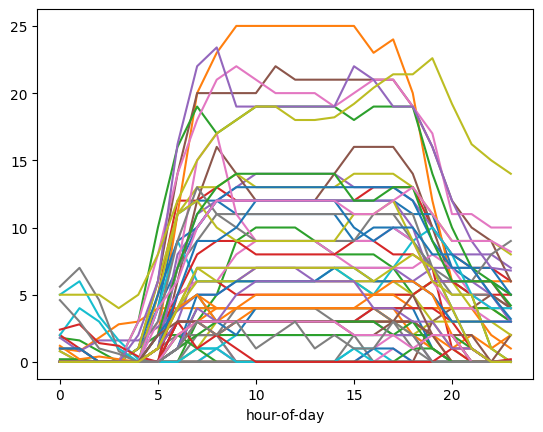

In [10]:
trips.groupby(trips.index.hour).mean().plot(legend=False)